In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import yaml
import ast
from pathlib import Path
from functools import partial
from tqdm.notebook import tqdm
from IPython.display import Audio
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset

class Vicente(Dataset):
    def __init__(self, categories):
        self.file_paths = []
        self.meta = pd.read_csv('../../datasets/Vicente/Metadata.csv', 
                                encoding='latin-1', sep=';', header=0, comment='#', parse_dates=[4])
        self.labels = []
        self.folder = []
        for file in Path('../../datasets/Vicente/').rglob('*.wav'):
            tag = self.match_ids(file)["Tag 1"].apply(lambda x: x.split(':')[0] if isinstance(x, str) else None)
            if len(tag) == 0:
                #print(id, file, tag)
                continue
            self.labels.append(tag.item().lower())
            #self.labels.append(tag.item())
            self.file_paths.append(file)
            self.folder.append(file.parent.stem)
        self.categories = categories
    
    def match_ids(self, file_name):
        id = file_name.stem
        if id[-3:] == '(1)':
            id = id[:-3]
        return self.meta.loc[self.meta['Id'] == id]         
        
    def __getitem__(self, idx):
        #return self.file_paths[idx], 'dog'
        return self.file_paths[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.file_paths)

In [3]:
import pickle
with open('UrbanSound_ESC-PANN-tag-pink-noise-pretrained.pkl', 'rb') as f:
    vicente_results = pickle.load(f)
    
th = 0.5
summarized_result = []
for name, percentages in vicente_results.items():
    summarized_result.append((percentages > th).sum()/12)


vicente_df = pd.DataFrame(summarized_result, index=list(vicente_results.keys()))
#display(vicente_df.head())
vicente_df.describe().T

count      mean       std  min  25%  50%  \
alerts/bells                117.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/horns                117.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/siren                117.0  0.078348  0.140679  0.0  0.0  0.0   
animal/bird                 117.0  0.000712  0.007704  0.0  0.0  0.0   
animal/dog                  117.0  0.095442  0.256212  0.0  0.0  0.0   
animal/others               117.0  0.000712  0.007704  0.0  0.0  0.0   
environmental/others        117.0  0.003561  0.025411  0.0  0.0  0.0   
environmental/rain          117.0  0.243590  0.357117  0.0  0.0  0.0   
environmental/waves         117.0  0.000000  0.000000  0.0  0.0  0.0   
environmental/wind          117.0  0.000000  0.000000  0.0  0.0  0.0   
humans/others               117.0  0.007123  0.025831  0.0  0.0  0.0   
mechanical/air_conditioner  117.0  0.003561  0.016927  0.0  0.0  0.0   
mechanical/cutting          117.0  0.000000  0.000000  0.0  0.0  0.0   
mechanical/digging          117.0  0.007835  0.084746  0.0  0.0  0.0   
mechanical/explosives       117.0  0.016382  0.069411  0.0  0.0  0.0   
mechanical/impact           117.0  0.002137  0.017168  0.0  0.0  0.0   
mechanical/others           117.0  0.080484  0.192325  0.0  0.0  0.0   
music/music                 117.0  0.005698  0.026185  0.0  0.0  0.0   
vehicles/airborne           117.0  0.001425  0.015408  0.0  0.0  0.0   
vehicles/others             117.0  0.000000  0.000000  0.0  0.0  0.0   

                                 75%       max  
alerts/bells                0.000000  0.000000  
alerts/horns                0.000000  0.000000  
alerts/siren                0.166667  0.750000  
animal/bird                 0.000000  0.083333  
animal/dog                  0.000000  1.000000  
animal/others               0.000000  0.083333  
environmental/others        0.000000  0.250000  
environmental/rain          0.416667  1.000000  
environmental/waves         0.000000  0.000000  
environmental/wind          0.000000  0.000000  
humans/others               0.000000  0.166667  
mechanical/air_conditioner  0.000000  0.083333  
mechanical/cutting          0.000000  0.000000  
mechanical/digging          0.000000  0.916667  
mechanical/explosives       0.000000  0.416667  
mechanical/impact           0.000000  0.166667  
mechanical/others           0.000000  0.916667  
music/music                 0.000000  0.166667  
vehicles/airborne           0.000000  0.166667  
vehicles/others             0.000000  0.000000

In [4]:
mask = vicente_df['animal/dog'] > 0.5
idxs = vicente_df.loc[mask].index
if len(idxs) > 0:
    print(idxs)
    for idx in idxs:
        print(vicente_df.index.get_loc(idx))

Index(['1654237499_1654237559(1).wav', '1654237378_1654237438(1).wav',
       '1654394260_1654394320(1).wav', '1654237439_1654237499(1).wav',
       '1654237560_1654237620.wav', '1654237863_1654237923(1).wav',
       '1654237620_1654237680(1).wav', '1654238106_1654238166(1).wav',
       '1654237257_1654237317(1).wav', '1654237985_1654238045(1).wav',
       '1654238045_1654238105(1).wav', '1654225332_1654225392(1).wav'],
      dtype='object')
74
76
79
86
93
94
96
98
101
105
109
116


Id             Tag 1                Tag 2  \
36  1654225332_1654225392  animal/dog:0.817  humans/others:0.074   

                         Tag 3        Fecha y hora  
36  environmental/others:0.065 2022-06-03 03:02:12

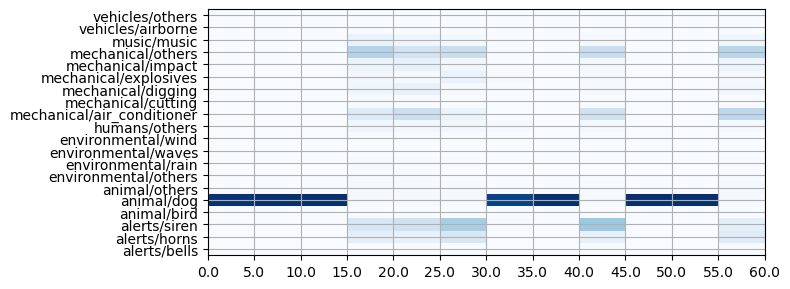

In [36]:
dataset = Vicente(categories=vicente_df.columns)
path, _ = dataset[116]
meta = dataset.match_ids(path)
display(meta)

#window_size = 32000*5
#preds = []
#with torch.no_grad():
#    for i in range(sample['waveform'].shape[-1]//window_size):
#        preds_ = torch.nn.Softmax(dim=-1)(model({'waveform': sample['waveform'][:, i*window_size:(i+1)*window_size].unsqueeze(0)})).detach()
#        preds.append(preds_.numpy())
#preds = np.stack(preds)[:, 0, :]
preds = vicente_results[path.name]
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.pcolormesh(preds.T, vmin=0, vmax=1, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(preds.shape[0]+1))
ax.set_xticklabels(np.linspace(0, 60, num=preds.shape[0]+1))
ax.set_yticks(np.arange(len(vicente_df.columns))+0.5)
ax.set_yticklabels(vicente_df.columns);
ax.grid()

waveform, rate = torchaudio.load(path)
Audio(data=waveform[0].numpy(), rate=rate)

d = [ast.literal_eval(d) for d in pd.read_csv('data/unstructured_data.csv')['predictions'].values]
d[0]